In [4]:
from math import ceil, sqrt as root
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNetCV, LassoCV 
from sklearn.ensemble import RandomForestRegressor
import warnings
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Exploratory Data Analysis

### We start by loading and viewing the data available to us.

In [5]:
train_set = pd.read_csv(r'C:\Users\efere\Downloads\Dataset\train.csv')
train_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test_set = pd.read_csv(r'C:\Users\efere\Downloads\Dataset\test.csv')
test_set.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [7]:
set(train_set.columns) - set(test_set.columns)

{'SalePrice'}

In [8]:
train_set["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'SalePrice distribution')

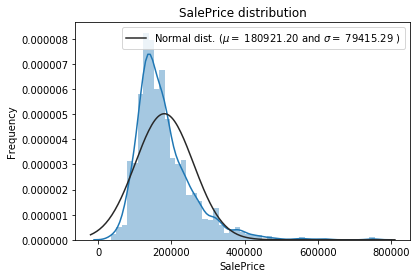

In [9]:
# Let's take a look at the distribution of the SalePrice 
sns.distplot(train_set['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train_set['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#### Looks like the price is left skewed so we work with the log of the prices.

Text(0.5, 1.0, 'SalePrice distribution')

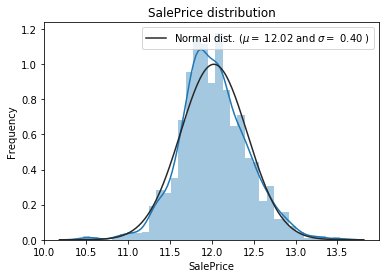

In [10]:
price = price = np.log1p(train_set.loc[~train_set.Electrical.isna()] ["SalePrice"])
 
sns.distplot(price , fit=norm);
(mu, sigma) = norm.fit(price)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#### Now that looks more like it...

#### What year did we have the most sales?

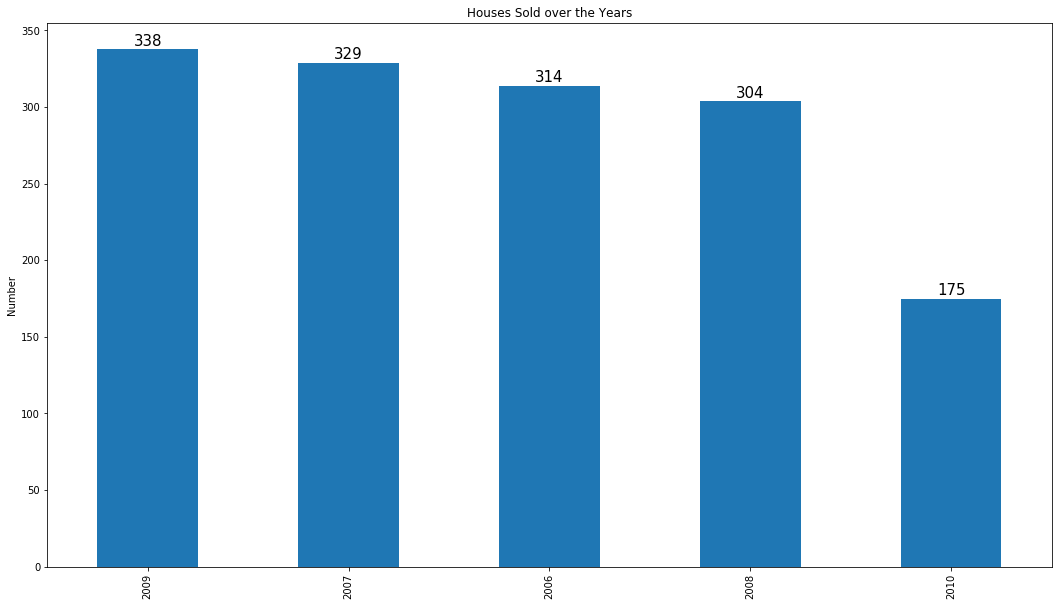

In [11]:
plt.figure(figsize=(18,10))
plots = train_set["YrSold"].value_counts().plot(kind="bar")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Houses Sold over the Years")
plt.ylabel("Number")
plt.show()

#### Looks like we had more house sales in 2009 and the least sales in 2010.
#### What type of sale was the most purchased?

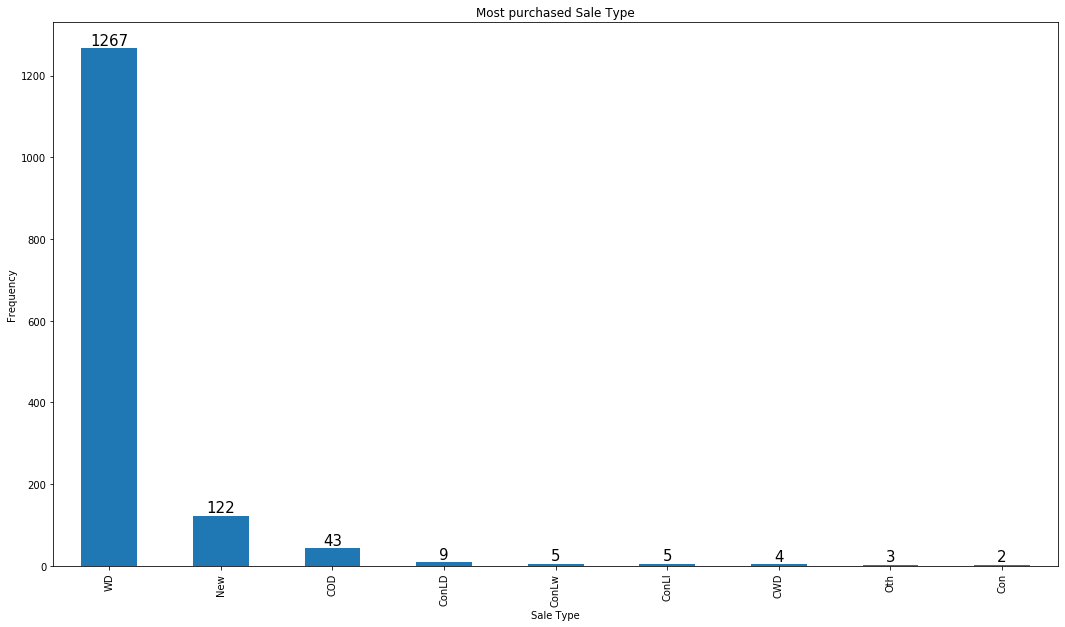

In [51]:
plt.figure(figsize=(18,10))
plots = train_set["SaleType"].value_counts().plot(kind="bar")
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Most purchased Sale Type")
plt.ylabel("Frequency")
plt.xlabel("Sale Type")
plt.show()

#### How about another look at the data

In [13]:
train_set.groupby(["YrSold", "MoSold"]).count()

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
YrSold MoSold                                                                  
2006   1       10          10        10            7       10      10      1   
       2        9           9         9            7        9       9      0   
       3       25          25        25           22       25      25      1   
       4       27          27        27           23       27      27      6   
       5       38          38        38           31       38      38      2   
       6       48          48        48           40       48      48      3   
       7       67          67        67           59       67      67      2   
       8       23          23        23           20       23      23      2   
       9       15          15        15           15       15      15      1   
       10      24          24        24           22       24      24      1   
       11      16          16        16           11       16      16      0   
       12      12          12        12            8       12      12      0   
2007   1       13          13        13           12       13      13      0   
       2        8           8         8            7        8       8      0   
       3       23          23        23           15       23      23      1   
       4       23          23        23           20       23      23      1   
       5       43          43        43           34       43      43      1   
       6       59          59        59           43       59      59      5   
       7       51          51        51           43       51      51      3   
       8       40          40        40           32       40      40      4   
       9       11          11        11           10       11      11      1   
       10      16          16        16           12       16      16      1   
       11      24          24        24           21       24      24      2   
       12      18          18        18           17       18      18      0   
2008   1       13          13        13           12       13      13      0   
       2       10          10        10           10       10      10      1   
       3       18          18        18           13       18      18      4   
       4       26          26        26           22       26      26      4   
       5       38          38        38           29       38      38      1   
       6       51          51        51           41       51      51      9   
       7       49          49        49           39       49      49      3   
       8       29          29        29           27       29      29      2   
       9       17          17        17           14       17      17      1   
       10      22          22        22           19       22      22      0   
       11      17          17        17           15       17      17      1   
       12      14          14        14           13       14      14      1   
2009   1       12          12        12            9       12      12      1   
       2       10          10        10            8       10      10      1   
       3       19          19        19           15       19      19      1   
       4       26          26        26           22       26      26      1   
       5       37          37        37           30       37      37      2   
       6       59          59        59           45       59      59      3   
       7       61          61        61           54       61      61      4   
       8       30          30        30           24       30      30      3   
       9       20          20        20           18       20      20      1   
       10      27          27        27           23       27      27      1   
       11      22          22        22           16       22      22      1   
       12      15          15        15            9       15      15      1   
2010   1       

#### Well, a closer look at the charts and data just shows that nothing spectacular happened in 2009. The number of purchases increase by the year and it is safe to say that the data available to us at the moment does not have complete records for the whole year 2010, only records up to the month of July in 2010 are available.

`Alley`, `PoolQC`, `Fence`, `MiscFeature` have the highest number of NaN values, we can fill this for EDA as nan means that feature is unavailable for the apartment. Other columns can be filled with their means if numerical and modes if categorical. However, I'll drop `MiscFeature`.

# Features Processing

#### In order to determine the features that play important roles in the determination of the sales price, we can start by checking the features that have strong positive or negative correlations with the sales price. 

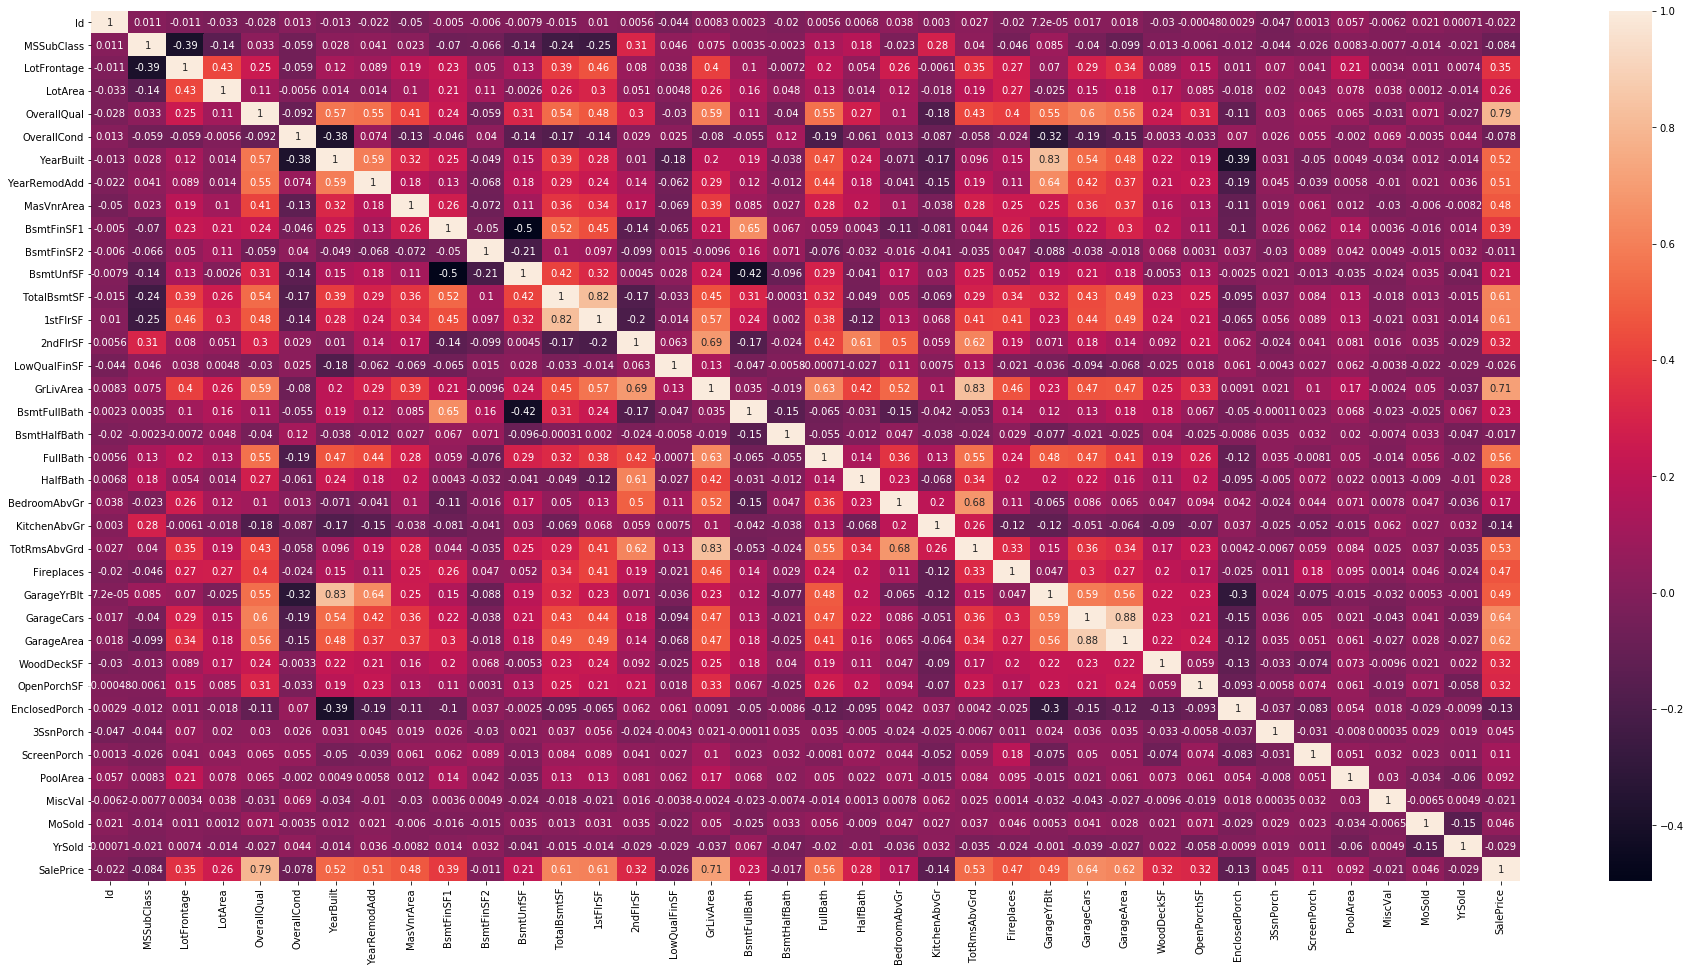

In [53]:
#correlation matrix
corr = train_set.corr()
f, ax = plt.subplots(figsize=(32, 16))
sns.heatmap(corr, annot=True)

In [15]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [16]:
train_set = train_set.drop(["PoolQC", "Fence", "MiscFeature", "Alley"], axis=1)

In [17]:
def clean_data(dataframe):
    df = dataframe.copy()
    df.loc[df.FireplaceQu.isna(),'FireplaceQu'] = 'None'
    df.loc[df.GarageType.isna(),'GarageType'] = 'None' 
    df.loc[df.GarageFinish.isna(),'GarageFinish'] = 'None' 
    df.loc[df.GarageQual.isna(),'GarageQual'] = 'None'
    df.loc[df.GarageCond.isna(),'GarageCond'] = 'None' 
    df.loc[df.BsmtExposure.isna(),'BsmtExposure'] = 'None' 
    df.loc[df.BsmtFinType2.isna(),'BsmtFinType2'] = 'None' 
    df.loc[df.BsmtCond.isna(),'BsmtCond'] = 'None' 
    df.loc[df.BsmtFinType1.isna(),'BsmtFinType1'] = 'None' 
    df.loc[df.BsmtQual.isna(),'BsmtQual'] = 'None'
    df.loc[df.MasVnrType.isna(),'MasVnrType'] = 'None' 
    df.loc[df.MasVnrArea.isna(),'MasVnrArea'] = 0
    df = df.loc[~df.Electrical.isna()] 
    df.loc[df.MSZoning.isna(),'MSZoning'] = 'None'
    df.loc[df.Utilities.isna(),'Utilities'] = 'None'
    df.loc[df.Exterior1st.isna(),'Exterior1st'] = 'None'
    df.loc[df.Exterior2nd.isna(),'Exterior2nd'] = 'None'
    df.loc[df.BsmtFinSF1.isna(),'BsmtFinSF1'] = 0
    df.loc[df.BsmtFinSF2.isna(),'BsmtFinSF2'] = 0
    df.loc[df.BsmtUnfSF.isna(),'BsmtUnfSF'] = 0
    df.loc[df.TotalBsmtSF.isna(),'TotalBsmtSF'] = 0
    df.loc[df.BsmtFullBath.isna(),'BsmtFullBath'] = 0
    df.loc[df.BsmtHalfBath.isna(),'BsmtHalfBath'] = 0
    df.loc[df.KitchenQual.isna(),'KitchenQual'] = 'None'
    df.loc[df.Functional.isna(),'Functional'] = 'None'
    df.loc[df.GarageCars.isna(),'GarageCars'] = 0
    df.loc[df.GarageArea.isna(),'GarageArea'] = 0
    df.loc[df.SaleType.isna(),'SaleType'] = 'None'
    return df

In [18]:
date_features = ['YearBuilt', 'YearRemodAdd']

def change_dates(df):
    data = df.copy()    
    for feature in date_features:
        data[feature] = data['YrSold'] - data[feature]
    
    return data

In [19]:
data = change_dates(train_set.copy().drop(["SalePrice", "Id", "GarageYrBlt"], axis=1))
numeric_feats = data.dtypes[data.dtypes != "object"].index

In [20]:
df = clean_data(data)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)

In [21]:
numeric_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [22]:
categorical_feats = ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 
                     'MasVnrType', 'Foundation', 'CentralAir', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleCondition']

In [24]:
skewed_feats = df[numeric_feats].apply(lambda x: skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df[skewed_feats] = np.log1p(df[skewed_feats])

In [25]:
def rank_columns(dataframe):
    df = dataframe.copy()
    df['ExterQual'] = df['ExterQual'].map({'Ex':5,'Fa':2,'Gd':4,'TA':3,'Po':1,'None':0}).astype('int64')
    df['ExterCond'] = df['ExterCond'].map({'Ex':5,'Fa':2,'Gd':4,'TA':3,'Po':1,'None':0}).astype('int64')
    df['BsmtQual'] = df['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}).astype('int64')
    df['BsmtCond'] = df['BsmtCond'].map({'Ex':5,'Fa':2,'Gd':4,'TA':3,'Po':1,'None':0}).astype('int64')
    df['BsmtExposure'] = df['BsmtExposure'].map({'Av':3,'Gd':4,'Mn':2,'No':1,'None':0}).astype('int64')
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'ALQ':5, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'None':0, 'Rec':3, 'Unf':1}).astype('int64')
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'ALQ':5, 'BLQ':4, 'GLQ':6, 'LwQ':2, 'None':0, 'Rec':3, 'Unf':1}).astype('int64')
    df['HeatingQC'] = df['HeatingQC'].map({'Ex':5, 'Fa':2, 'Gd':4, 'Po':1, 'TA':3,'None':0}).astype('int64')
    df['KitchenQual'] = df['KitchenQual'].map({'Ex':5,'Fa':2,'Gd':4,'TA':3,'Po':1,'None':0}).astype('int64')
    df['FireplaceQu'] = df['FireplaceQu'].map({'Ex':5, 'Fa':2, 'Gd':4, 'None':0, 'Po':1, 'TA':3}).astype('int64')
    df['GarageCond'] = df['GarageCond'].map({'Ex':5, 'Fa':2, 'Gd':4, 'None':0, 'Po':1, 'TA':3}).astype('int64')
    df['GarageQual'] = df['GarageQual'].map({'Ex':5, 'Fa':2, 'Gd':4, 'None':0, 'Po':1, 'TA':3}).astype('int64')
    return df

In [26]:
remaining = ['MSZoning', 'Utilities', 'Condition2', 'HouseStyle', 'RoofMatl', 'Exterior1st',
             'Exterior2nd', 'Heating', 'Electrical', 'Functional', 'SaleType']

In [27]:
df = rank_columns(df)
scaler = MinMaxScaler()
df[numeric_feats] = scaler.fit_transform(df[numeric_feats])
oe_enc = OrdinalEncoder(dtype=int, unknown_value=-1, handle_unknown="use_encoded_value")
df[remaining] = oe_enc.fit_transform(df[remaining])

In [28]:
def new_features(df):
    df['Bathrooms'] = df['BsmtFullBath'] + df['BsmtHalfBath']*0.5 + df['FullBath'] + df['HalfBath']*0.5
    df['Rooms'] = df['TotalBsmtSF'].apply(lambda x: 1 if x==0 else 0) + df['Bathrooms'] + df['TotRmsAbvGrd']
    df['TotalUsedSF'] = df['MasVnrArea'] + df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GarageArea'] + df['EnclosedPorch'] + df['OpenPorchSF'] + df['WoodDeckSF'] + df['PoolArea'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    return df


In [29]:
df = new_features(df)
encoder = OneHotEncoder(handle_unknown="ignore")
train_data = encoder.fit_transform(df).toarray()

# Modelling

In [30]:
#For cross validation
def rmsle_cv(model):
    kf = KFold(
        n_splits=5,
        shuffle=True,
        random_state=42).get_n_splits(train_data)

    rmse = np.sqrt(-cross_val_score(
        model,
        train_data,
        price,
        scoring="neg_mean_squared_error",
        cv = kf)
    )
    return rmse

In [31]:
# Prepare test set
test_set1 = test_set.copy().drop(["Id", "PoolQC", "Fence", "MiscFeature", "Alley", "GarageYrBlt"], axis=1)
test_data = change_dates(test_set1)
test_df = clean_data(test_data)
test_df['LotFrontage'].fillna(test_df['LotFrontage'].mean(), inplace = True)
test_df[skewed_feats] = np.log1p(test_df[skewed_feats])
test_df = rank_columns(test_df)
test_df[numeric_feats] = scaler.transform(test_df[numeric_feats])
test_df[remaining] = oe_enc.transform(test_df[remaining])
test_data = new_features(test_df)
test_data = encoder.transform(test_data).toarray()

In [32]:
test_df.isnull().sum()[test_df.isnull().sum() > 0]

Series([], dtype: int64)

## Linear Models

### Linear Regression

In [33]:
lin_selector = SelectFromModel(
    estimator=LinearRegression(),
    threshold="median"
)
lin_selector.fit(train_data, price)

SelectFromModel(estimator=LinearRegression(), threshold='median')

In [34]:
linear_reg = LinearRegression()
linear_reg.fit(train_data, price)

LinearRegression()

In [35]:
rmsle_cv(linear_reg)

array([0.13779183, 0.15762246, 0.15452991, 0.13824987, 0.16079942])

In [36]:
# Predict the test data using the Linear Model.
predicted_linear_reg = linear_reg.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_linear_reg)}).head(10)

,id,SalePrice
0,1461,117164.850931
1,1462,157941.124871
2,1463,180818.926833
3,1464,203773.227475
4,1465,195562.890881
5,1466,167945.672146
6,1467,166697.986985
7,1468,179213.755613
8,1469,169888.757040
9,1470,139204.572231


### Lasso 

In [38]:
lasso = LassoCV(alphas = [0.0003, 0.0005, 0.001, 0.0001, 1, 10], random_state=0)
lasso.fit(train_data, price)

LassoCV(alphas=[0.0003, 0.0005, 0.001, 0.0001, 1, 10], random_state=0)

In [39]:
rmsle_cv(lasso)

array([0.13066564, 0.15576312, 0.14740587, 0.13427329, 0.14698115])

In [40]:
# Predict the test data using the Lasso Model.
predicted_lasso = lasso.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_lasso)}).head(10)

,id,SalePrice
0,1461,123135.477436
1,1462,152802.571571
2,1463,173470.407804
3,1464,201445.948967
4,1465,199761.269665
5,1466,174326.083781
6,1467,173869.099363
7,1468,172621.546366
8,1469,180408.670646
9,1470,131774.310009


## Ridge

In [41]:
ridge = Ridge(alpha=10, solver="auto", random_state=0)
ridge.fit(train_data, price) 

Ridge(alpha=10, random_state=0)

In [42]:
rmsle_cv(ridge)

array([0.13081521, 0.15515941, 0.15068224, 0.13650387, 0.1543484 ])

In [43]:
# Predict the test data using the Ridge.
predicted_ridge = ridge.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_ridge)}).head(10)

,id,SalePrice
0,1461,118523.787176
1,1462,155493.049614
2,1463,178192.262914
3,1464,203311.234755
4,1465,192329.470602
5,1466,168312.242771
6,1467,167308.394611
7,1468,177076.314444
8,1469,179190.671686
9,1470,133713.301479


## Elastic Net

In [44]:
elastic_net = ElasticNetCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1, 0.0005, 0.0003, 0.005], random_state=0)
elastic_net.fit(train_data, price)

ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 0.0005, 0.0003, 0.005], cv=5,
             random_state=0)

In [45]:
rmsle_cv(elastic_net)

array([0.13003487, 0.1555608 , 0.14794154, 0.13439945, 0.14837526])

In [46]:
# Predict the test data using the Elastic Net.
predicted_elastic = elastic_net.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_elastic)}).head(10)

,id,SalePrice
0,1461,123746.240280
1,1462,153652.892449
2,1463,173285.281574
3,1464,202369.447511
4,1465,196769.323735
5,1466,173804.844171
6,1467,173250.431496
7,1468,171807.089582
8,1469,180008.739552
9,1470,132799.611301


## Random Forest

In [47]:
## making predictions using the Random Forest algorithm 

forest_model = RandomForestRegressor(max_features=0.5, n_estimators=1000, random_state=0)
forest_model.fit(train_data, price)

RandomForestRegressor(max_features=0.5, n_estimators=1000, random_state=0)

In [48]:
rmsle_cv(forest_model)

array([0.14244103, 0.18355236, 0.17854638, 0.16423263, 0.16770255])

In [49]:
# Predict the test data using the Random Forest Model.
predicted_rf = forest_model.predict(test_data)
pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_rf)}).head(10)

,id,SalePrice
0,1461,121218.545778
1,1462,147776.716791
2,1463,176862.188244
3,1464,184885.667218
4,1465,199184.535235
5,1466,177856.206333
6,1467,173456.375623
7,1468,176574.410433
8,1469,178411.832876
9,1470,133156.586345


# Submission

In [50]:
submission = pd.DataFrame({'id': test_set['Id'], 'SalePrice': np.expm1(predicted_lasso)})
submission.to_csv("submission.csv",index = False)
print("predictions successfully submitted")

predictions successfully submitted
